In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import ERFutils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta

In [2]:
# Convolution error data
conv_1pctCO2_short = [(0.2134, 0.1526, 0.0294),(0.332, 0.2212, 0.0427),(0.3074, 0.2108, 0.015),(0.3277, 0.2243, 0.0183),(0.3601, 0.2428, 0.0201)]
conv_ssp126_short  = [(0.3695, 0.2918, 0.2593),(0.2269, 0.1635, -0.0038),(0.2344, 0.1672, 0.0426),(0.2288, 0.169, 0.0961),(0.2863, 0.2166, 0.1385)]
conv_ssp245_short  = [(0.2971, 0.2325, 0.161),(0.2532, 0.1779, -0.0458),(0.2283, 0.1629, -0.0037),(0.2018, 0.1496, 0.0471),(0.2541, 0.194, 0.0838)]
conv_ssp370_short  = [(0.2877, 0.2051, 0.0497),(0.2853, 0.199, -0.0819),(0.2528, 0.1784, -0.041),(0.1966, 0.1448, 0.0091),(0.2568, 0.1929, 0.0426)]
conv_ssp585_short  = [(0.264, 0.1942, 0.0246),(0.2924, 0.2005, -0.1144),(0.2546, 0.1777, -0.076),(0.2093, 0.1508, -0.0273),(0.2279, 0.1653, 0.0028)]

conv_1pctCO2_long = [(0.2472, 0.1787, -0.0287),(0.3642, 0.2213, -0.0451),(0.3171, 0.21, -0.0375),(0.3161, 0.2214, -0.0523),(0.3547, 0.2344, -0.0711)]
conv_ssp126_long  = [(0.5306, 0.3619, 0.2969),(0.2234, 0.1621, 0.0713),(0.2842, 0.2042, 0.1508),(0.48, 0.327, 0.2774),(0.5655, 0.373, 0.322)]
conv_ssp245_long  = [(0.3944, 0.2722, 0.1263),(0.2416, 0.169, -0.0086),(0.2108, 0.1517, 0.0488),(0.3384, 0.2362, 0.1535),(0.4045, 0.2708, 0.1785)]
conv_ssp370_long  = [(0.3519, 0.2404, -0.0875),(0.3508, 0.2204, -0.1121),(0.2926, 0.1848, -0.0722),(0.2334, 0.1704, 0.0181),(0.264, 0.1942, 0.0246)]
conv_ssp585_long  = [(0.3323, 0.2403, -0.0137),(0.3453, 0.2184, -0.0571),(0.297, 0.19, -0.0273),(0.2606, 0.1922, 0.0505),(0.2363, 0.1766, 0.0537)]

In [3]:
# Pattern error data
pattern_1pctCO2_short = [(0.2684, 0.1774, 0.0),(0.2465, 0.1658, -0.0),(0.249, 0.1683, 0.0),(0.2316, 0.1573, 0.0),(0.2471, 0.1734, 0.0)]
pattern_ssp126_short  = [(0.2197, 0.1525, 0.0),(0.1839, 0.1301, 0.0),(0.2106, 0.1456, 0.0),(0.204, 0.144, 0.0),(0.2129, 0.1481, 0.0)]
pattern_ssp245_short  = [(0.2111, 0.15, 0.0),(0.1951, 0.1379, 0.0),(0.2016, 0.1406, 0.0),(0.1809, 0.1285, 0.0),(0.1943, 0.1396, 0.0)]
pattern_ssp370_short  = [(0.2366, 0.1654, 0.0),(0.2156, 0.1502, 0.0),(0.2126, 0.147, 0.0),(0.1786, 0.1252, 0.0),(0.2002, 0.1436, 0.0)]
pattern_ssp585_short  = [(0.2289, 0.1527, 0.0),(0.2175, 0.1468, -0.0),(0.2164, 0.1475, -0.0),(0.1975, 0.1366, -0.0),(0.1998, 0.1402, -0.0)]

pattern_1pctCO2_long = [(0.2879, 0.1766, 0.0),(0.247, 0.1593, 0.0),(0.2311, 0.1512, 0.0),(0.2297, 0.1643, -0.0),(0.2313, 0.1682, 0.0)]
pattern_ssp126_long  = [(0.4642, 0.2627, 0.0),(0.1833, 0.1304, 0.0),(0.2055, 0.1402, 0.0),(0.3466, 0.2138, 0.0),(0.4289, 0.2418, 0.0)]
pattern_ssp245_long  = [(0.3789, 0.2211, 0.0),(0.1951, 0.1377, 0.0),(0.1766, 0.1245, 0.0),(0.2594, 0.1681, 0.0),(0.3241, 0.1938, 0.0)]
pattern_ssp370_long  = [(0.327, 0.2027, 0.0),(0.2201, 0.1514, 0.0),(0.1947, 0.1379, 0.0),(0.199, 0.1394, 0.0),(0.2491, 0.1682, 0.0)]
pattern_ssp585_long  = [(0.2961, 0.1813, -0.0),(0.227, 0.1506, -0.0),(0.2046, 0.1393, -0.0),(0.2017, 0.146, -0.0),(0.1969, 0.1385, -0.0)]

In [4]:
conv_all_short = [conv_1pctCO2_short,conv_ssp126_short,conv_ssp245_short,conv_ssp370_short,conv_ssp585_short]
conv_all_long = [conv_1pctCO2_long,conv_ssp126_long,conv_ssp245_long,conv_ssp370_long,conv_ssp585_long]

patt_all_short = [pattern_1pctCO2_short,pattern_ssp126_short,pattern_ssp245_short,pattern_ssp370_short,pattern_ssp585_short]
patt_all_long = [pattern_1pctCO2_long,pattern_ssp126_long,pattern_ssp245_long,pattern_ssp370_long,pattern_ssp585_long]

num_exp = len(conv_all_short)

In [36]:
save = False
if save:
    import pickle
    output_path = ERFutils.path_to_ERF_outputs
    with open(f'{output_path}conv_all_short.pickle', 'wb') as handle:
        pickle.dump(conv_all_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}conv_all_long.pickle', 'wb') as handle:
        pickle.dump(conv_all_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}patt_all_short.pickle', 'wb') as handle:
        pickle.dump(patt_all_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}patt_all_long.pickle', 'wb') as handle:
        pickle.dump(patt_all_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
RMSE_all_conv_short = np.zeros((num_exp,num_exp))
MAE_all_conv_short = np.zeros((num_exp,num_exp))
bias_all_conv_short = np.zeros((num_exp,num_exp))

RMSE_all_patt_short = np.zeros((num_exp,num_exp))
MAE_all_patt_short = np.zeros((num_exp,num_exp))
bias_all_patt_short = np.zeros((num_exp,num_exp))

RMSE_all_conv_long = np.zeros((num_exp,num_exp))
MAE_all_conv_long = np.zeros((num_exp,num_exp))
bias_all_conv_long = np.zeros((num_exp,num_exp))

RMSE_all_patt_long = np.zeros((num_exp,num_exp))
MAE_all_patt_long = np.zeros((num_exp,num_exp))
bias_all_patt_long = np.zeros((num_exp,num_exp))

for i in range(num_exp):
    for j in range(num_exp):
        RMSE_all_conv_short[i,j] = conv_all_short[i][j][0]
        MAE_all_conv_short[i,j] = conv_all_short[i][j][1]
        bias_all_conv_short[i,j] = conv_all_short[i][j][2]
        
        RMSE_all_patt_short[i,j] = patt_all_short[i][j][0]
        MAE_all_patt_short[i,j] = patt_all_short[i][j][1]
        bias_all_patt_short[i,j] = patt_all_short[i][j][2]
        
        RMSE_all_conv_long[i,j] = conv_all_long[i][j][0]
        MAE_all_conv_long[i,j] = conv_all_long[i][j][1]
        bias_all_conv_long[i,j] = conv_all_long[i][j][2]
        
        RMSE_all_patt_long[i,j] = patt_all_long[i][j][0]
        MAE_all_patt_long[i,j] = patt_all_long[i][j][1]
        bias_all_patt_long[i,j] = patt_all_long[i][j][2]

In [6]:
RMSE_all_conv_short[0] = [0.187, 0.2256, 0.2307, 0.2345, 0.2445]
MAE_all_conv_short[0] = [0.133, 0.159, 0.1615, 0.1654, 0.1739]
bias_all_conv_short[0] = [0.0109, 0.0173, 0.0109, 0.0223, 0.0204]

RMSE_all_conv_long[0] = [0.1885, 0.3015, 0.2278, 0.2563, 0.2861]
MAE_all_conv_long[0] = [0.1378, 0.1884, 0.1502, 0.1811, 0.1864]
bias_all_conv_long[0] = [-0.0081, 0.0074, 0.0017, 0.0004, -0.0135]


In [7]:
print(np.mean(MAE_all_conv_short[0]))
print(np.mean(RMSE_all_conv_short[0]))
print(np.mean(MAE_all_patt_short[0]))
print(np.mean(RMSE_all_patt_short[0]))
print()
print(np.mean(MAE_all_conv_long[0]))
print(np.mean(RMSE_all_conv_long[0]))
print(np.mean(MAE_all_patt_long[0]))
print(np.mean(RMSE_all_patt_long[0]))
print()
print(np.mean(bias_all_conv_short[0]))
print(np.mean(bias_all_conv_long[0]))

0.15855999999999998
0.22445999999999997
0.16844
0.24852

0.16878
0.25204
0.16392
0.24539999999999998

0.01636
-0.00242


In [8]:
print(np.std(MAE_all_conv_short[0]))
print(np.std(RMSE_all_conv_short[0]))
print(np.std(MAE_all_patt_short[0]))
print(np.std(RMSE_all_patt_short[0]))
print()
print(np.std(MAE_all_conv_long[0]))
print(np.std(RMSE_all_conv_long[0]))
print(np.std(MAE_all_patt_long[0]))
print(np.std(RMSE_all_patt_long[0]))
print()
print(np.std(bias_all_conv_short[0]))
print(np.std(bias_all_conv_long[0]))

0.013742285108379897
0.019727605024432132
0.006869818047081016
0.011728836259407845

0.02074689374340169
0.040618793679773404
0.008513377708054543
0.022174760427116226

0.0047352296670805745
0.007434890718766484


/tmp/ipykernel_541/2304702121.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


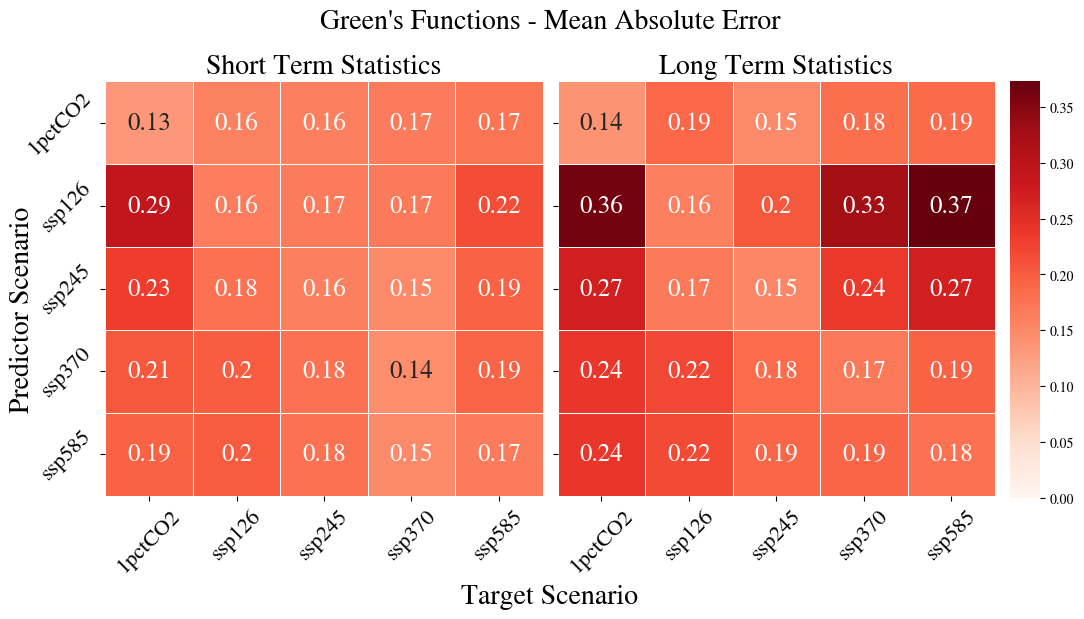

In [169]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures

experiments = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
save = False

def plot_res(data, experiments, title, plot_title = None):
    #fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6),sharey=True)
    fig, axes = plt.subplots(1,2,figsize=(10,6),sharey=True)

    if 'Bias' in title:
        cmap = 'vlag'
        vmin = np.min([data1,data2])
        vmax = np.max([data1,data2])
    else:
        cmap = 'Reds'
        vmin = 0
        
    vmax = np.max(data)
    
    #if title == 'Bias':
    #    sns.heatmap(data1, ax = ax1, vmin = vmin, vmax = vmax, annot = True,
    #                cmap = cmap, center = 0.0, linewidth=0.5, yticklabels=experiments, xticklabels=experiments,  annot_kws={"fontsize":18},
    #                cbar_ax=None)
    #    sns.heatmap(data2, ax = ax2, vmin = vmin, vmax = vmax, annot = True,
    #                cmap = cmap, center = 0.0, linewidth=0.5, yticklabels=experiments, xticklabels=experiments,  annot_kws={"fontsize":18},
    #                cbar_ax=None)
    #else: 
    cbar_ax = fig.add_axes([1, 0.185, .03, .695])
    for i, ax in enumerate(axes.flat):
        #sns.heatmap(data1, ax = ax1, vmin = vmin, vmax = vmax, annot = True,
        #            cmap = cmap, linewidth=0.5, yticklabels=experiments, xticklabels=experiments, annot_kws={"fontsize":18},cbar=False)
        im = sns.heatmap(data[i], ax = ax, vmin = vmin, vmax = vmax, annot = True,
                         cmap = cmap, linewidth=0.5, yticklabels=experiments, xticklabels=experiments, annot_kws={"fontsize":18},
                         cbar_ax=cbar_ax)
    
    axes[0].set_title(f'Short Term Statistics',fontsize = 20)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45)
    axes[0].tick_params(axis='both', which='major', labelsize=16)
    
    axes[1].set_title(f'Long Term Statistics',fontsize = 20)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].tick_params(axis='both', which='major', labelsize=16)  
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(f'Green\'s Functions - Mean Absolute Error',fontsize=20,y=1,x=0.54)
    fig.supxlabel('Target Scenario',fontsize=20,y=0.00,x=0.54)
    fig.supylabel('Predictor Scenario',fontsize=20,x=0.00) 
    
    if plot_title and save:
        plt.savefig(f'{figure_path}heatmap_loess_{plot_title}_v2.pdf', bbox_inches = 'tight', dpi = 350)
    
    return

plot_res([MAE_all_conv_short, MAE_all_conv_long], experiments, 'MAE: conv', 'MAE_GF')

#plot_res(RMSE_all_conv_short, RMSE_all_patt_short, experiments, 'RMSE: Short Term', 'RMSE_short')
#plot_res(MAE_all_conv_short, MAE_all_patt_short, experiments, 'MAE: Short Term', 'MAE_short')
#plot_res(bias_all_conv_short, bias_all_conv_long, experiments, 'Bias', 'bias_both')

#plot_res(RMSE_all_conv_long, RMSE_all_patt_long, experiments, 'RMSE: Long Term', 'RMSE_long')
#plot_res(MAE_all_conv_long, MAE_all_patt_long, experiments, 'MAE: Long Term', 'MAE_long')

In [2]:
def calc_area_error(truth_path, emulator_path, start_year, end_year):

    truth = xr.open_dataset(truth_path) 

    if 'patt' in emulator_path:
        emulator = xr.open_dataset(emulator_path)
    else:
        emulator = xr.open_dataset(emulator_path)['__xarray_dataarray_variable__']
        emulator.name = 'tas'
    
    if (start_year == 1875 or start_year == 1915) and 'conv' in emulator_path:
        truth = truth.sel(s = slice(165,250)).assign_coords(s = range(0,85))
    
    slice_start = start_year - 1850
    slice_end = end_year - 1850
    
    truth = truth.mean(dim = 'model')
    truth = truth.sel(s = slice(slice_start,slice_end))    
    
    if 'conv' in emulator_path:
        emulator = emulator.mean(dim = 'train_id')
        
    emulator = emulator.sel(s = slice(slice_start,slice_end))
    
    # For each grid point, calculate % error from truth
    pct_error_spatial = np.divide(np.subtract(emulator,truth['tas']),truth['tas']).mean(dim = 's')

    # We have a few grid cells bugged in ssp126 when performing this operation, that varies between the short and long term; can't figure out why
    if 'ssp126' in truth_path and '1pctCO2' in emulator_path and start_year == 2040:
        pct_error_spatial.loc[{'lat': -62.5, 'lon': 153}] = np.nan
    elif 'ssp126' in truth_path and '1pctCO2' in emulator_path and start_year == 2080:
        pct_error_spatial = pct_error_spatial.where(pct > -10, np.nan)
        pct_error_spatial = pct_error_spatial.where(pct < 10, np.nan)
    
    pct_error_stacked = pct_error_spatial.stack(allpoints=['lat','lon'])
    
    
    mn = pct_error_spatial.weighted(A).mean(dim = ['lat','lon'])
    std = pct_error_spatial.weighted(A).std(dim = ['lat','lon'])
    
    # Create dataset of total area
    total_area = xr.DataArray(np.ones((len(truth.lon.values),len(truth.lat.values))),
                              coords={'lon': ('lon', truth.lon.values),
                              'lat': ('lat', truth.lat.values)})
    total_area.to_dataset(name = 'area')

    area_pct = []
    area_stack = A.stack(allpoints=['lat','lon'])

    # Create histogram of error by area on the planet 
    n_bins = 100
    if 'patt' in emulator_path:
        counts, bins = np.histogram(pct_error_stacked.tas.values, range = (-0.25,0.25), bins = n_bins)
    else:
        counts, bins = np.histogram(pct_error_stacked.values, range = (-0.25,0.25), bins = n_bins)
    seen = set()
    for i in range(n_bins):
        bin_l = bins[i]
        bin_r = bins[i+1]
        area_count = 0
        for j in range(len(pct_error_stacked['allpoints'].values)):
            if j in seen:
                continue

            if 'patt' in emulator_path:
                test_val = pct_error_stacked.tas.values[j]
            else:
                test_val = pct_error_stacked.values[j]

            if bin_l <= test_val <= bin_r:
                area_count += area_stack[j]
                seen.add(j)

        area_pct.append(area_count)
        
    # Scale each bin by the total surface area of the Earth
    surf_earth = sum(sum(A))
    for i in range(n_bins):
        if type(area_pct[i]) is int:
            area_pct[i] = area_pct[i]/surf_earth
        else:
            area_pct[i] = area_pct[i].values/surf_earth
    
    return area_pct, bins, mn, std


In [ ]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

A = ERFutils.A
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures

conv_id = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
train_id = ['1pctCO2']

area_pct_short, area_pct_long = {}, {}
bins_short, bins_long = {}, {}
max_s_l = {}

save = True

for train in train_id:
    for conv in conv_id:
        truth_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
        emulator_path = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, end_yr1 = 2040, 2060
            start_yr2, end_yr2 = 2080, 2100
        elif 'ssp' in conv:
            start_yr1, end_yr1 = 1875, 1895
            start_yr2, end_yr2 = 1915, 1935
        else: # 1pctCO2
            start_yr1, end_yr1 = 1940, 1960
            start_yr2, end_yr2 = 1980, 2000

        area_pct_short[conv], bins_short[conv], mn_short, std_short = calc_area_error(truth_path, emulator_path, start_yr1, end_yr1)
        area_pct_long[conv], bins_long[conv], mn_long, std_long = calc_area_error(truth_path, emulator_path, start_yr2, end_yr2)

        max_s_l[conv] = max(float(max(area_pct_short[conv])),float(max(area_pct_long[conv])))

        print(f'Short Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_short),4)}, std: {round(float(std_short),4)}, max: {round(float(max(area_pct_short[conv])),4)}')
        print(f'Long Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_long),4)}, std: {round(float(std_long),4)}, max: {round(float(max(area_pct_long[conv])),4)}')
        
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,6),sharey=True)
    
    for conv in conv_id:
        ax1.stairs(area_pct_short[conv], bins_short[conv], label = f'Target: {conv}', linewidth = 3)
        ax2.stairs(area_pct_long[conv], bins_long[conv], label = f'Target: {conv}', linewidth = 3)

    max_max = max([max_s_l[k] for k in max_s_l.keys()])
        
    ax1.set_title(f'Mid-Century Statistics',fontsize=20)
    ax1.set_ylim(0,max_max*1.05)
    ax1.set_yticks(ticks = [0.0,0.1,0.2,0.3,0.4,0.5],labels = ['0%','10%','20%','30%','40%','50%'])
    ax1.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=18)

    ax2.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
    ax2.set_title(f'End-of-Century Statistics',fontsize=20)
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    
    fig.tight_layout(rect=[0.01, 0.03, 1, 0.95])
    fig.suptitle(f'Spatially Explicit Errors\nPredictor: {train}',fontsize=20,y=1.04,x=0.52)
    fig.supxlabel('Relative Error: (Emulator - CMIP6)/CMIP6',fontsize=20,y=0.0,x=0.52)
    fig.supylabel('Coverage (Earth\'s Surface Area)',fontsize=20,x=0.0)
    
    if save:
        plt.savefig(f'{figure_path}area_loess_comp_conv_{train}_v3.pdf', bbox_inches = 'tight', dpi = 350)


In [ ]:
save = False
if save:
    import pickle
    output_path = ERFutils.path_to_ERF_outputs
    with open(f'{output_path}area_pct_short.pickle', 'wb') as handle:
        pickle.dump(area_pct_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}area_pct_long.pickle', 'wb') as handle:
        pickle.dump(area_pct_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}bins_short.pickle', 'wb') as handle:
        pickle.dump(bins_short, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{output_path}bins_long.pickle', 'wb') as handle:
        pickle.dump(bins_long, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

A = ERFutils.A

conv_id = ['1pctCO2']
train_id = ['1pctCO2']

area_pct_short_conv, area_pct_long_conv = {}, {}
area_pct_short_patt, area_pct_long_patt = {}, {}
bins_short_conv, bins_long_conv = {}, {}
bins_short_patt, bins_long_patt = {}, {}

color1 = '#648efe'
color2 = '#FFAB3F'

save = True

for train in train_id:
    for conv in conv_id:
        
        truth_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
        emulator_path_conv = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'
        emulator_path_patt = f'{output_path}Spatial Results/res_pattern_spatial_{train}_{conv}_all_ds.nc4'

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, end_yr1 = 2040, 2060
            start_yr2, end_yr2 = 2080, 2100
            start_yr1_patt, end_yr1_patt, start_yr2_patt, end_yr2_patt = start_yr1, end_yr1, start_yr2, end_yr2
        elif 'ssp' in conv:
            start_yr1, end_yr1 = 1875, 1895
            start_yr2, end_yr2 = 1915, 1935
            
            start_yr1_patt, end_yr1_patt = 2040, 2060
            start_yr2_patt, end_yr2_patt = 2080, 2100
        else: # 1pctCO2
            start_yr1, end_yr1 = 1940, 1960
            start_yr2, end_yr2 = 1980, 2000
            start_yr1_patt, end_yr1_patt, start_yr2_patt, end_yr2_patt = start_yr1, end_yr1, start_yr2, end_yr2

        area_pct_short_conv[conv], bins_short_conv[conv], mn_short_conv, std_short_conv = calc_area_error(truth_path, emulator_path_conv, start_yr1, end_yr1)
        area_pct_long_conv[conv], bins_long_conv[conv], mn_long_conv, std_long_conv = calc_area_error(truth_path, emulator_path_conv, start_yr2, end_yr2)
        
        area_pct_short_patt[conv], bins_short_patt[conv], mn_short_patt, std_short_patt = calc_area_error(truth_path, emulator_path_patt, start_yr1_patt, end_yr1_patt)
        area_pct_long_patt[conv], bins_long_patt[conv], mn_long_patt, std_long_patt = calc_area_error(truth_path, emulator_path_patt, start_yr2_patt, end_yr2_patt)

        print(f'GF: Short Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_short_conv),4)}, std: {round(float(std_short_conv),4)}, max: {round(float(max(area_pct_short_conv[conv])),4)}')
        print(f'GF: Long Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_long_conv),4)}, std: {round(float(std_long_conv),4)}, max: {round(float(max(area_pct_long_conv[conv])),4)}')
        
        print(f'PS: Short Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_short_patt.tas.values),4)}, std: {round(float(std_short_patt.tas.values),4)}, max: {round(float(max(area_pct_short_patt[conv])),4)}')
        print(f'PS: Long Term - Predictor: {train}, Target: {conv}, mean: {round(float(mn_long_patt.tas.values),4)}, std: {round(float(std_long_patt.tas.values),4)}, max: {round(float(max(area_pct_long_patt[conv])),4)}')
        
    max_s_l_conv = max(float(max(area_pct_short_conv[conv])),float(max(area_pct_long_conv[conv])))
    max_s_l_patt = max(float(max(area_pct_short_patt[conv])),float(max(area_pct_long_patt[conv])))
    max_max = max(max_s_l_conv, max_s_l_patt)
      
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,6),sharey=True)
    
    for conv in conv_id:
        ax1.stairs(area_pct_short_conv[conv], bins_short_conv[conv], label = f'Green\'s Function', linewidth = 3, color=color1)
        ax1.stairs(area_pct_short_patt[conv], bins_short_patt[conv], label = f'Pattern Scaling', linewidth = 3, color=color2)
        
        ax2.stairs(area_pct_long_conv[conv], bins_long_conv[conv], label = f'Green\'s Function', linewidth = 3, color=color1)
        ax2.stairs(area_pct_long_patt[conv], bins_long_patt[conv], label = f'Pattern Scaling', linewidth = 3, color=color2)
    

    ax1.set_title(f'Mid-Century Statistics',fontsize=20)
    ax1.set_ylim(0,max_max*1.05)
    ax1.set_yticks(ticks = [0.0,0.1,0.2,0.3,0.4,0.5],labels = ['0%','10%','20%','30%','40%','50%'])
    ax1.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=18)

    ax2.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
    ax2.set_title(f'End-of-Century Statistics',fontsize=20)
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    
    fig.tight_layout(rect=[0.01, 0.03, 1, 0.95])
    fig.suptitle(f'Spatially Explicit Errors\nPredictor: {train}, Target: {conv}',fontsize=20,y=1.04,x=0.52)
    fig.supxlabel('Relative Error: (Emulator - CMIP6)/CMIP6',fontsize=20,y=0.0,x=0.52)
    fig.supylabel('Coverage (Earth\'s Surface Area)',fontsize=20,x=0.0)
    
    if save:
        plt.savefig(f'{figure_path}area_comp_conv_patt_loess_{train}_{conv}_v3.pdf', bbox_inches = 'tight', dpi = 350)
    
    

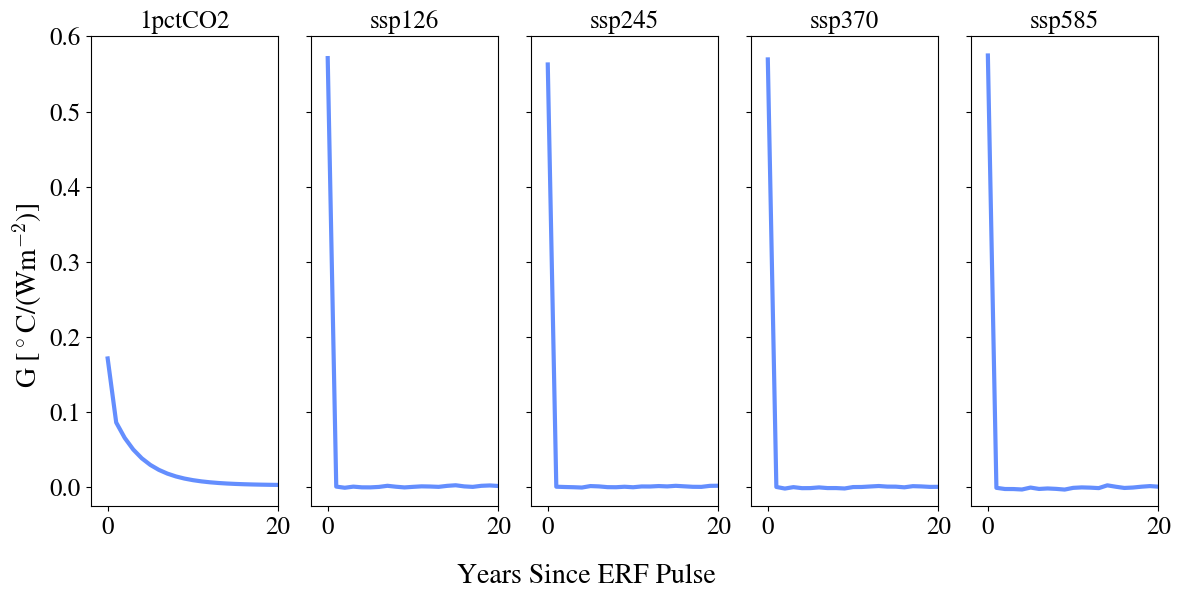

In [25]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
save = False

train_id = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
A = ERFutils.A

output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
color1 = '#648efe'
color2 = '#FFAB3F'

i = 0
fig, ax = plt.subplots(nrows=1, ncols=len(train_id),figsize = [12,6],sharey=True,sharex=True)
for train in train_id:
    if train == '1pctCO2':# or train == 'ssp585' or train == 'ssp370' or train == 'ssp126':
        G_ds_path = f'{output_path}GFs/G_loess_man_{train}_ERF_mean_ds.nc4'
        G_ds = xr.open_dataset(G_ds_path)['G[tas]']
    else:
        #continue
        G_ds_path = f'{output_path}GFs/G_{train}_ERF_all_ds.nc4'
        G_ds = xr.open_dataset(G_ds_path)['__xarray_dataarray_variable__']
    G_ds.name = 'G'
    
    if train == '1pctCO2':# or train == 'ssp585' or train == 'ssp370' or train == 'ssp126':
        G_ds = G_ds.sel(year  = slice(0,84))
        #print(np.trapz(G_ds.weighted(A).mean(dim = ['lat','lon']).values))
        ax[i].plot(G_ds.weighted(A).mean(dim = ['lat','lon']).values, label = train, linewidth=3, color=color1)
    else:
        ax[i].plot(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'model').values, label = train, linewidth=3, color=color1)
        
    ax[i].set_title(f'{train}',fontsize=18)
    ax[i].tick_params(axis='both', which='major', labelsize=18)
        
    i += 1
    
plt.setp(ax, xlim=[-2,20], ylim=[-0.025,0.6]) 
fig.supxlabel('Years Since ERF Pulse',fontsize=20)
fig.supylabel('G [$^\circ$C/(Wm$^{-2}$)]',fontsize=20)
fig.tight_layout()

if save:
    plt.savefig(f'{figure_path}GF_all_loess_v2.pdf', bbox_inches = 'tight', dpi = 350)

In [17]:
print(G_ds.lat.values)

[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5
 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5
 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5
 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5
 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5
 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5
 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5
  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5
   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5
  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5
  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5
  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5
  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5
  66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  7

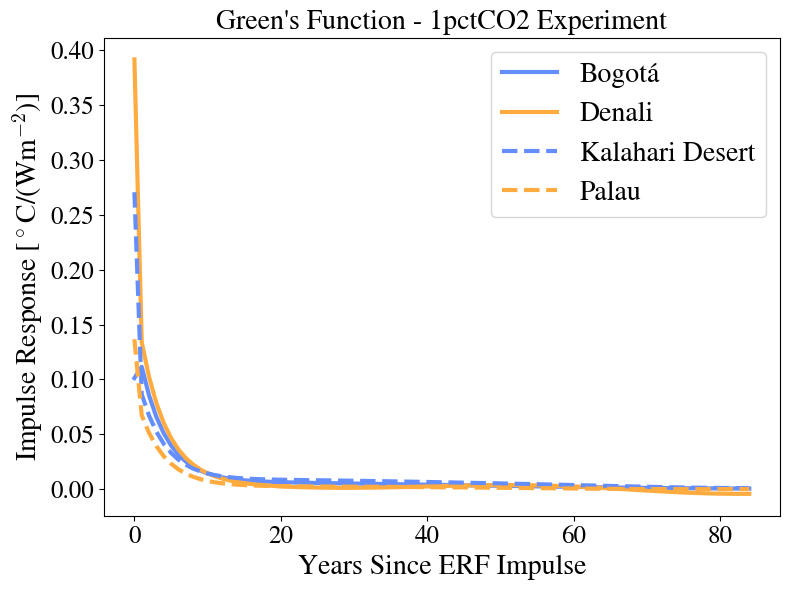

In [75]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
save = True

train = '1pctCO2'
A = ERFutils.A

output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
color1 = '#648efe'
color2 = '#FFAB3F'

ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
ERF_ds = xr.open_dataset(ERF_path)
ERF = ERFutils.ds_to_dict(ERF_ds)
ERF = ERFutils.concat_multirun(ERF,'model').mean(dim = 'model')
ERF = ERF.sel(year = slice(0,144))

tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
tas_ds = xr.open_dataset(tas_path)
tas_glob_mean = tas_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model'])
tas_glob_mean = tas_glob_mean.rename({'s': 'year'})
tas_glob_mean = tas_glob_mean.sel(year = slice(0,144))

G_ds_path = f'{output_path}GFs/G_loess_man_{train}_ERF_mean_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['G[tas]']
G_ds.name = 'G'
    
G_ds = G_ds.sel(year  = slice(0,84))

fig, ax = plt.subplots(figsize = [8,6])

lats = [3.5, 63.5, -20.5, 7.5]
lons = [287, 210, 21, 134]
locs = ['Bogotá','Denali','Kalahari Desert','Palau']

if True:
    #ax.plot(G_ds.weighted(A).mean(dim = ['lat','lon']).values, label = train, linewidth=3, color=color1)
    ax.plot(G_ds.sel(lat = lats[0], lon = lons[0]).values, linewidth=3, color=color1, label=locs[0])
    ax.plot(G_ds.sel(lat = lats[1], lon = lons[1]).values, linewidth=3, color=color2, label=locs[1])
    ax.plot(G_ds.sel(lat = lats[2], lon = lons[2]).values, linestyle='--',linewidth=3, color=color1, label=locs[2])
    ax.plot(G_ds.sel(lat = lats[3], lon = lons[3]).values, linestyle='--',linewidth=3, color=color2, label=locs[3])
    ax.set_title(f'Green\'s Function - {train} Experiment',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

    ax.set_xlabel('Years Since ERF Impulse',fontsize=20)
    ax.set_ylabel('Impulse Response [$^\circ$C/(Wm$^{-2}$)]',fontsize=20)
    ax.legend(fontsize=20)

if False:
    ax2 = ax.twinx()
    ax.plot(ERF.ERF.values, label = 'ERF', linewidth=3, color=color1)
    ax2.plot(tas_glob_mean.tas.values, label = '$\Delta T$', linewidth=3, color=color2)
    ax.set_title(f'Climate Variables - {train} Experiment',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=18)

    ax.set_xlabel('Year',fontsize=20)
    ax.set_ylabel('ERF [Wm$^{-2}$]',fontsize=20)
    ax2.set_ylabel('$\Delta T$ [$^\circ$C]',fontsize=20)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left',fontsize=20)
    

fig.tight_layout()

if save:
    plt.savefig(f'{figure_path}cities_{train}_v2.pdf', bbox_inches = 'tight', dpi = 350)
    #plt.savefig(f'{figure_path}climvars_{train}_loess_v2.pdf', bbox_inches = 'tight', dpi = 350)

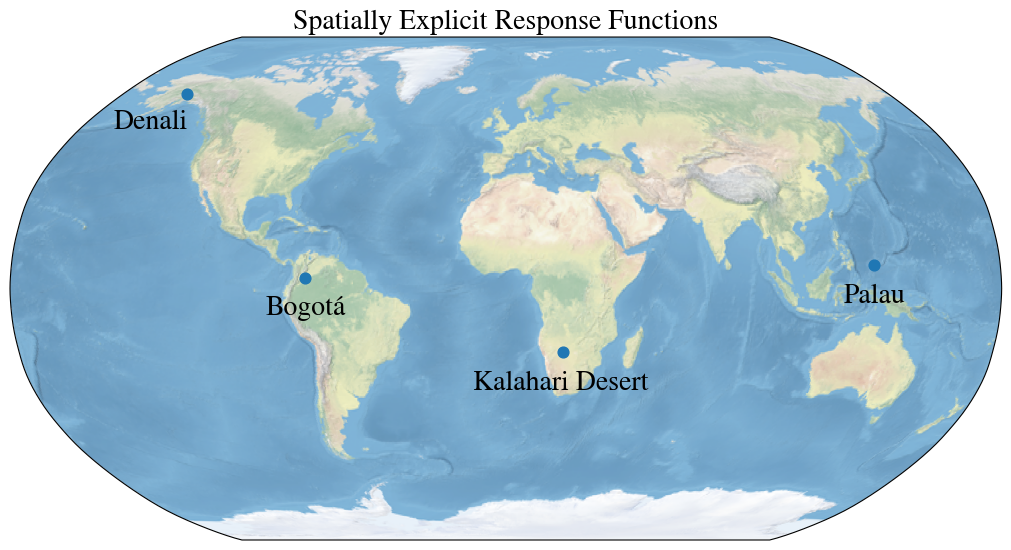

In [76]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize = [10,6], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)

#ax = plt.axes(figsize = [8,6],projection=ccrs.Robinson())
ax.stock_img()

plt.scatter(lons, lats, marker='o',
         transform=ccrs.Geodetic(),
         s=60)

plt.text(lons[0], lats[0] - 12, locs[0],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)

plt.text(lons[1], lats[1] - 12, locs[1],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)

plt.text(lons[2], lats[2] - 12, locs[2],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)

plt.text(lons[3], lats[3] - 12, locs[3],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)
if save:
    ax.set_title('Spatially Explicit Response Functions',fontsize=20)
    plt.savefig(f'{figure_path}cities_v1.pdf', bbox_inches = 'tight', dpi = 350)

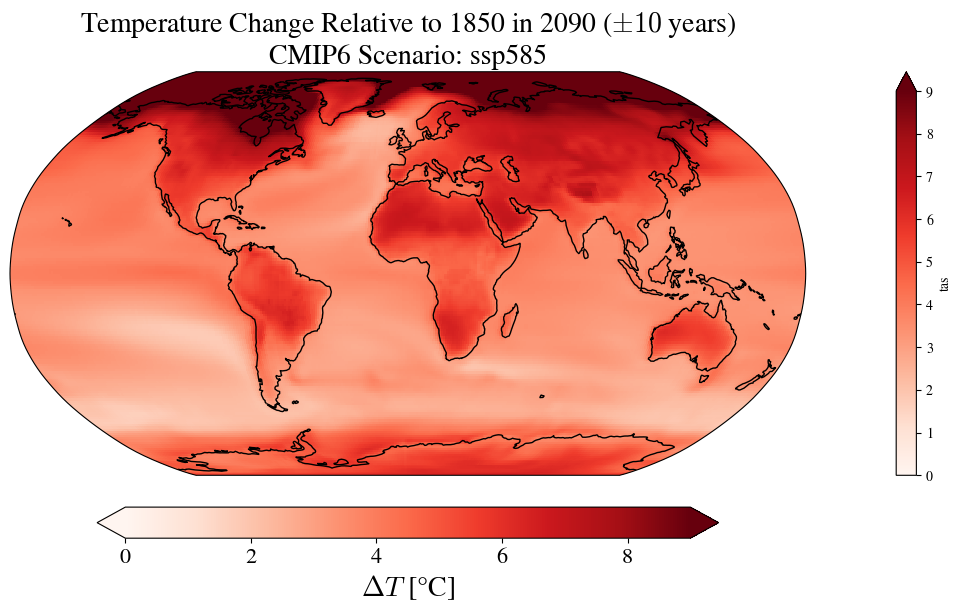

In [50]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
save = True

output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures

train_id = ['1pctCO2']#,'ssp126','ssp245','ssp370','ssp585']
conv_id = ['ssp585']#,'ssp585']#,'ssp245','ssp370','ssp585']

for train in train_id:
    for conv in conv_id:

        tas_CMIP_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
        tas_CMIP = xr.open_dataset(tas_CMIP_path)

        conv_ds_path = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'
        conv_ds = xr.open_dataset(conv_ds_path)['__xarray_dataarray_variable__']

        conv_mean_ds_path = f'{output_path}Global Mean Results/res_conv_global_{train}_{conv}_all_ds.nc4'
        conv_mean_ds = xr.open_dataset(conv_mean_ds_path)['__xarray_dataarray_variable__']

        if 'ssp' in conv and 'ssp' in train:
            tas_CMIP = tas_CMIP.sel(s = slice(165,250)).assign_coords(s = range(0,85))

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, plot_yr1, end_yr1 = 2040, 2050, 2060
            start_yr2, plot_yr2, end_yr2 = 2080, 2090, 2100
        elif 'ssp' in conv:
            start_yr1, plot_yr1, end_yr1 = 1875, 1885, 1895
            start_yr2, plot_yr2, end_yr2 = 1915, 1925, 1935
        elif 'hist' in conv:
            start_yr, plot_yr, end_yr = 1850, 1975, 2015
        else: # 1pctCO2
            start_yr1, plot_yr1, end_yr1 = 1940, 1950, 1960
            start_yr2, plot_yr2, end_yr2 = 1980, 1990, 2000

        # Make plots for analysis
        model_color = ERFutils.model_color
        type_color = ERFutils.type_color
        #ERFutils.plot_conv_meanGF(train, conv, conv_mean_ds, tas_CMIP, save_fig = save)
        ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr2, yr_dif = 10, train_id = train, conv_id = conv, dif = False, save_fig = save)

        #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr1, yr_dif = 10, train_id = train, conv_id = conv, save_fig = save)
        #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr2, yr_dif = 10, train_id = train, conv_id = conv, save_fig = save)

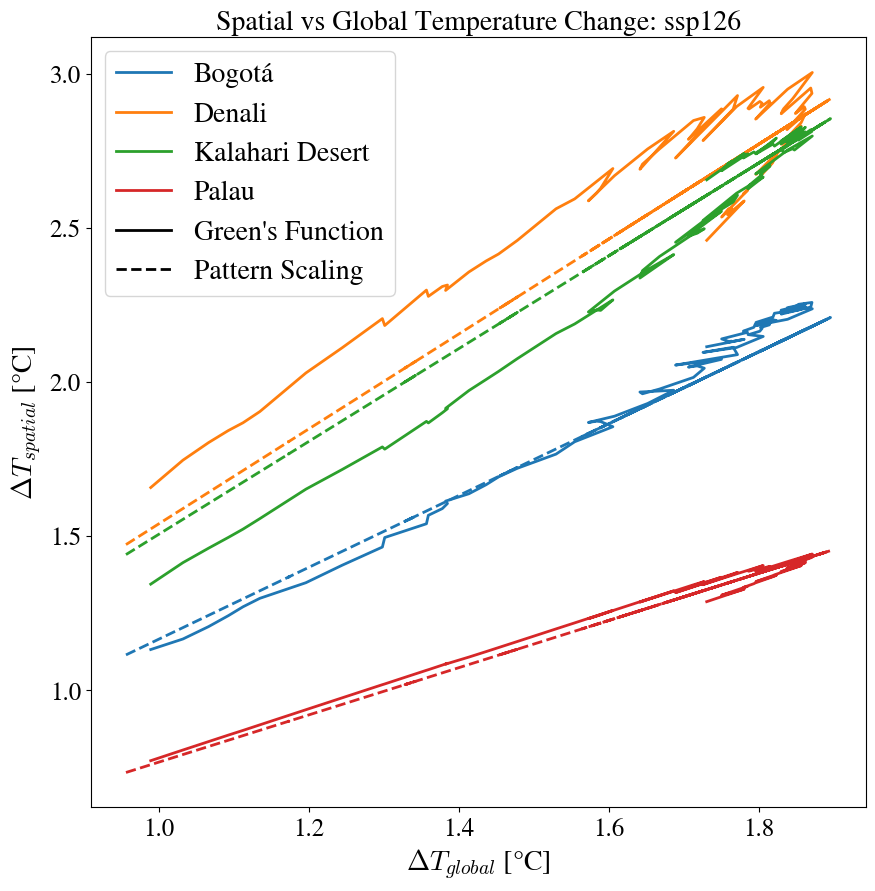

In [42]:
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
save = False
A = ERFutils.A

output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures

train = '1pctCO2'
conv = 'ssp126'

tas_CMIP_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
tas_CMIP = xr.open_dataset(tas_CMIP_path)
tas_glob_mean = tas_CMIP.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model'])

conv_ds_path = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'
conv_ds = xr.open_dataset(conv_ds_path)['__xarray_dataarray_variable__']

conv_mean_ds_path = f'{output_path}Global Mean Results/res_conv_global_{train}_{conv}_all_ds.nc4'
conv_mean_ds = xr.open_dataset(conv_mean_ds_path)['__xarray_dataarray_variable__']

patt_ds_path = f'{output_path}Spatial Results/res_pattern_spatial_{train}_{conv}_all_ds.nc4'
patt_ds = xr.open_dataset(patt_ds_path)

# Make plots for analysis
model_color = ERFutils.model_color
type_color = ERFutils.type_color

lat_lon = [(3.5,287),(63.5,210),(-20.5, 21),(7.5, 134)]
locs = ['Bogotá','Denali','Kalahari Desert','Palau']

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label=locs[0]),
                   Line2D([0], [0], color=colors[1], lw=2, label=locs[1]),
                   Line2D([0], [0], color=colors[2], lw=2, label=locs[2]),
                   Line2D([0], [0], color=colors[3], lw=2, label=locs[3]),
                   Line2D([0,1],[0,1],color='k', lw=2, label='Green\'s Function'),
                   Line2D([0,1],[0,1],linestyle='--', color='k', lw=2, label = 'Pattern Scaling')]
                   #Line2D([0,1],[0,1],linestyle='-.', color='k', lw=2, label = 'CMIP6')]        
        

fig, ax = plt.subplots(figsize=(10,10))
i = 0
for lat, lon in lat_lon:
    ax.plot(conv_mean_ds.sel(s=slice(165,250)).values[0],conv_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).values[0],
            linewidth=2,c=colors[i])
    ax.plot(tas_glob_mean.sel(s=slice(165,250)).tas.values,patt_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).tas.values,
            linewidth=2,c=colors[i],linestyle='--')
    i += 1
    
ax.set_ylabel('$\Delta T_{spatial}$ [$\degree$C]', fontsize = 20)
ax.set_xlabel('$\Delta T_{global}$ [$\degree$C]', fontsize = 20)
ax.set_title(f'Spatial vs Global Temperature Change: ssp126',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(handles=legend_elements,fontsize=20)

In [39]:
A = ERFutils.A

output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures

train = '1pctCO2'
conv = 'ssp245'

tas_CMIP_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'
tas_CMIP = xr.open_dataset(tas_CMIP_path)
tas_glob_mean = tas_CMIP.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model'])

conv_ds_path = f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4'
conv_ds = xr.open_dataset(conv_ds_path)['__xarray_dataarray_variable__']

conv_mean_ds_path = f'{output_path}Global Mean Results/res_conv_global_{train}_{conv}_all_ds.nc4'
conv_mean_ds = xr.open_dataset(conv_mean_ds_path)['__xarray_dataarray_variable__']

conv_mean_ds.sel(s=slice(165,250)).values[0]

lat_lon = [(3.5,287),(63.5,210),(-20.5, 21),(7.5, 134)]
locs = ['Bogotá','Denali','Kalahari Desert','Palau']

i = 0
for lat, lon in lat_lon:
    print(locs[i])
    print(np.mean(np.divide((conv_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).values[0] - conv_mean_ds.sel(s=slice(165,250)).values[0]),conv_mean_ds.sel(s=slice(165,250)).values[0])))
    i += 1

Bogotá
0.17675276863606718
Denali
0.6312493359850585
Kalahari Desert
0.4385480976434725
Palau
-0.22440988771391224
